In [1]:
#Importing all the required packages

import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
from datetime import datetime
import plotly.express as px 
import plotly.graph_objects as go
import statsmodels.api as sm
from pylab import * 
from scipy import stats
import numpy as np
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from sklearn.metrics import mean_squared_error

In [2]:
#Loading the dataset

df=pd.read_csv("D:/Samana K/HPE CTY 2022-2023/dataset/CPU_data_uses.csv")
df.head()

Timestamp  CPU-Usage
0  06.07.2021 00:00:00        148
1  06.07.2021 00:05:00        156
2  06.07.2021 00:10:00        146
3  06.07.2021 00:15:00        277
4  06.07.2021 00:20:00        138

In [3]:
#Converting time data to datetime object

df.loc[:,'Timestamp']=pd.to_datetime(df['Timestamp'],format='%d.%m.%Y %H:%M:%S')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3168 entries, 0 to 3167
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   Timestamp  3168 non-null   datetime64[ns]
 1   CPU-Usage  3168 non-null   int64         
dtypes: datetime64[ns](1), int64(1)
memory usage: 49.6 KB


In [4]:
#Setting the datetime as index

df=df.set_index('Timestamp')
df.head()

CPU-Usage
Timestamp                     
2021-07-06 00:00:00        148
2021-07-06 00:05:00        156
2021-07-06 00:10:00        146
2021-07-06 00:15:00        277
2021-07-06 00:20:00        138

In [5]:
#Plotting the entire series and seeing if it can be forecasted. 
figure=px.line(x=df.index,y=df['CPU-Usage'])
figure.update_layout(title='CPU Uses',xaxis_title='Time Index',yaxis_title='CPU-Usages')
figure.update_xaxes(rangeslider_visible=True)
figure.show()

In [6]:
#Mean and variance of the data
print("Mean : \n"+str(df.mean())+"\n")
print("Variance :\n "+str(df.var()))

Mean : 
CPU-Usage    159.279356
dtype: float64

Variance :
 CPU-Usage    654.497559
dtype: float64


In [7]:
#Check for the missing values

df.isnull().sum()

CPU-Usage    0
dtype: int64

Implies data has no missing values

In [8]:
#Checking if the data has white noise or not.

A time series may be white noise. If a time series is white noise, it is a sequence of random numbers and cannot be predicted. 

In short, white noise distribution is any distribution that has:
1) Zero mean
2) A constant variance/standard deviation (does not change over time)
3) Zero autocorrelation at all lags

C:\Users\Samana K\AppData\Roaming\Python\Python39\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning:

The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.



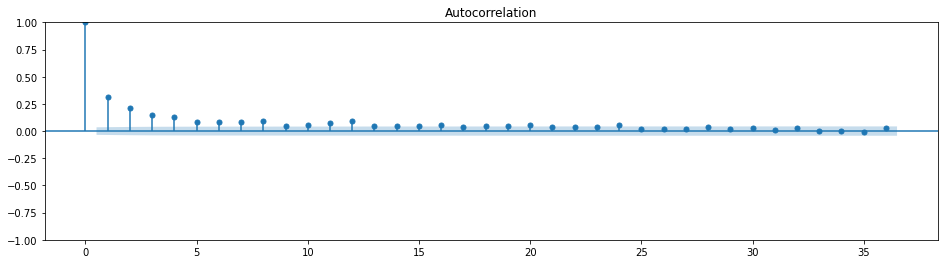

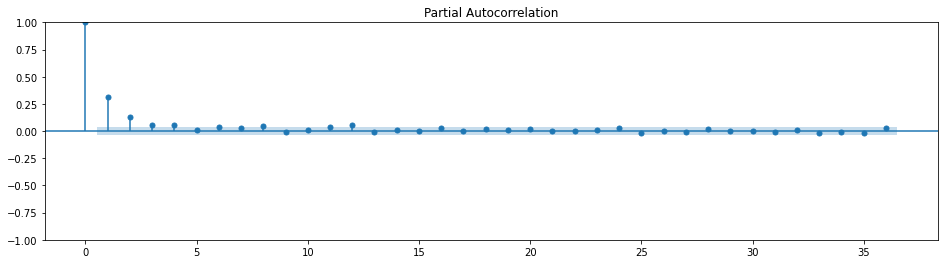

In [9]:
#ACF and PACF plots to check white noise.

plt.rcParams["figure.figsize"] = (16,4)

sm.graphics.tsa.plot_acf(df.values.squeeze())
sm.graphics.tsa.plot_pacf(df.values.squeeze())
plt.show()

Here as the autocorrelation at all lags is not zero, data might have some noise. To verify this performing the ljung-box test.

The Ljung-Box test is a hypothesis test that checks if a time series is white noise or not.
There are two hypothesis-Null hypothesis and Alternate hypothesis.
Null hypothesis states that there is no autocorrelation between the signal and lagged version of itself and Alternate hypothesis states that there is significant autocorrelation.

In [10]:
from statsmodels.stats.diagnostic import acorr_ljungbox
acorr_ljungbox(df, lags=[1], return_df=True, boxpierce=True)

lb_stat     lb_pvalue     bp_stat     bp_pvalue
1  310.185977  1.989349e-69  309.892425  2.304937e-69

Here we see a p-value much smaller than 0.05, thus we reject the null hypothesis of the test and conclude that the residuals are not independent.

This proves that the data is not white noise.

In [11]:
#Check for the frequency of the data using periodogram / FT and use that frequency to decompose the data

#Estimate power spectral density using a periodogram

from scipy import signal
f, Pxx = signal.periodogram(df['CPU-Usage'])

In [12]:
top_3_periods = {}

# get indices for 3 highest Pxx values
top3_freq_indices = np.flip(np.argsort(Pxx), 0)[0:3]

# use indices from previous step to
# get 3 frequencies with highest power
freqs = f[top3_freq_indices]

# use same indices to get powers as well
power = Pxx[top3_freq_indices]

# we are interested in period and it is calculated as 1/frequency 
periods = 1 / np.array(freqs)

# populate dict with calculated values
top_3_periods['period1'] = periods[0]
top_3_periods['freq1'] = freqs[0]
top_3_periods['power1'] = power[0]

top_3_periods['period2'] = periods[1]
top_3_periods['freq2'] = freqs[1]
top_3_periods['power2'] = power[1]

top_3_periods['period3'] = periods[2]
top_3_periods['freq3'] = freqs[2]
top_3_periods['power3'] = power[2]

In [13]:
# lets plot this periodogram
fig=px.line(f, Pxx)
fig.update_xaxes()
fig.show()

In [14]:
top_3_periods

{'period1': 211.2,
 'freq1': 0.004734848484848485,
 'power1': 22776.053102951842,
 'period2': 57.599999999999994,
 'freq2': 0.017361111111111112,
 'power2': 17513.76377850757,
 'period3': 158.39999999999998,
 'freq3': 0.006313131313131314,
 'power3': 16239.214348324374}

From these results we can see that strongest seasonal component has period of 58 ('period2': 57.5999) , next one is 158 and third one is approx 211

Detecting outliers - There are different techniques to detect outliers. Here we have used Box plot method and Z-scores method.

In [15]:
#Box plot method
fig=px.box(df,x='CPU-Usage',width=1000)
fig.show()

Detecting outliers using the Z-scores -  Baic criteria: any data point whose Z-score falls out of 3rd standard deviation is an outlier.

<img src="outlier.png">

In [16]:
z = np.abs(stats.zscore(df['CPU-Usage']))

threshold = 3
outliers=np.where(z > 3)
print(outliers)

(array([   3,  109,  110,  125,  126,  129,  130,  133,  141,  149,  178,
        294,  295,  569,  570,  577,  579,  581,  582,  629, 1129, 1409,
       1708, 2018, 2019, 2020, 2021, 2183, 2200, 2645, 2933], dtype=int64),)


These are indices of dataframe which are considered as outliers.

Handling Outliers - There are different method of treating the outliers
Trimming/removing the outlier is not a good practice to follow as forecasting might not yield good results. So we go for Mean/Median imputation. As the mean value is highly influenced by the outliers, it is advised to replace the outliers with the median value.

In [17]:
median = int(np.median(df['CPU-Usage']))
df1=df.copy()
for i in outliers:
    df1['CPU-Usage'][i] = median
df1.describe()

CPU-Usage
count  3168.000000
mean    157.523359
std      12.879347
min     130.000000
25%     151.000000
50%     154.000000
75%     160.000000
max     236.000000

In [18]:
#Verifying this result using box plot

fig=px.box(df1['CPU-Usage'],height=700)
fig.show()

Checking for stationarity of data using Augmented-Dickey Fuller test:
The Augmented Dickey-Fuller test is a type of statistical test called a unit root test.It uses an autoregressive model and optimizes an information criterion across multiple different lag values.

Null Hypothesis (H0): If failed to be rejected, it suggests the time series has a unit root, meaning it is non-stationary. It has some time dependent structure.

Alternate Hypothesis (H1): The null hypothesis is rejected; it suggests the time series does not have a unit root, meaning it is stationary. It does not have time-dependent structure.

We interpret this result using the p-value from the test. A p-value below a threshold (such as 5% or 1%) suggests we reject the null hypothesis (stationary), otherwise a p-value above the threshold suggests we fail to reject the null hypothesis (non-stationary).

In [19]:
dftest = adfuller(df1['CPU-Usage'], autolag = 'AIC')
print("1. ADF : ",dftest[0])
print("2. P-Value : ", dftest[1])
print("3. Num Of Lags : ", dftest[2])
print("4. Num Of Observations Used For ADF Regression and Critical Values Calculation :", dftest[3])
print("5. Critical Values :")
for key, val in dftest[4].items():
    print("\t",key, ": ", val)

1. ADF :  -7.852529877882442
2. P-Value :  5.5519749002778566e-12
3. Num Of Lags :  24
4. Num Of Observations Used For ADF Regression and Critical Values Calculation : 3143
5. Critical Values :
	 1% :  -3.432432293604288
	 5% :  -2.862460029008544
	 10% :  -2.5672597530168955


Here, as the p-value is much lesser than 0.05, the data is considered to be stationary.

Time series data is a combination of several components such as level, trend, seasonality and noise. These components are either additively or multiplicatively combined.

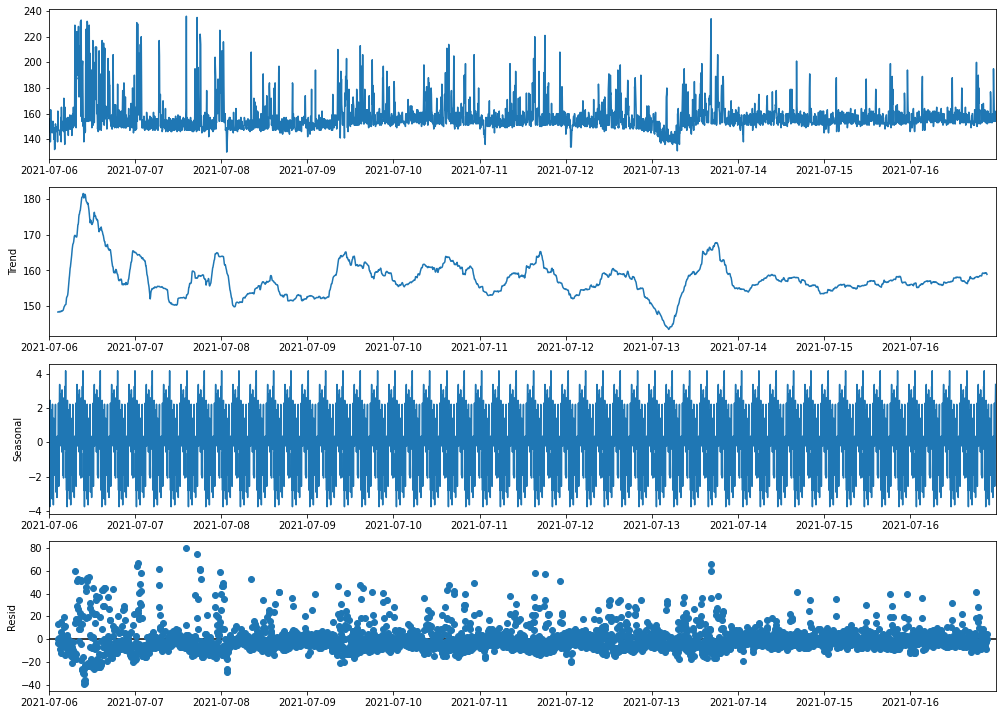

In [20]:
#Seasonal decomposition considering additive model.

import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (14,10)

from statsmodels.tsa.seasonal import seasonal_decompose
decompose_data = seasonal_decompose(df1, model="additive",period=58)
decompose_data.plot()
plt.show()

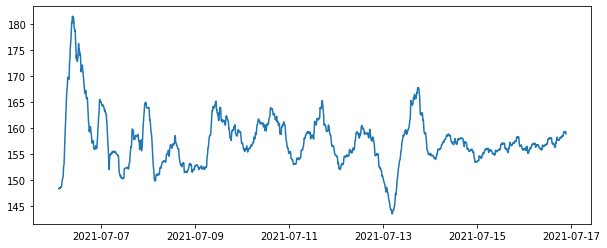

In [21]:
#Trend
plt.rcParams["figure.figsize"] = (10,4)
plt.plot(decompose_data.trend)

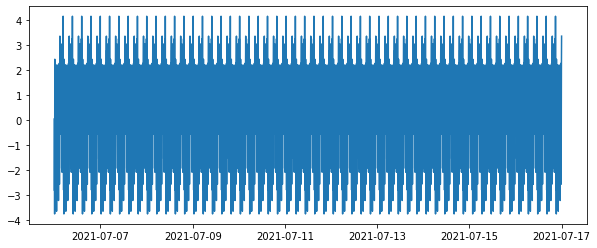

In [22]:
#Seasonal
plt.plot(decompose_data.seasonal)

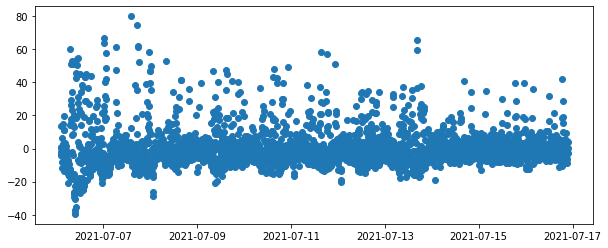

In [23]:
#Residual
plt.scatter(x=df.index,y=decompose_data.resid)

In [24]:
decompose_data.resid.describe()

count    3110.000000
mean        0.003365
std        11.534236
min       -39.511801
25%        -6.030718
50%        -2.137751
75%         2.508204
max        79.984528
Name: resid, dtype: float64

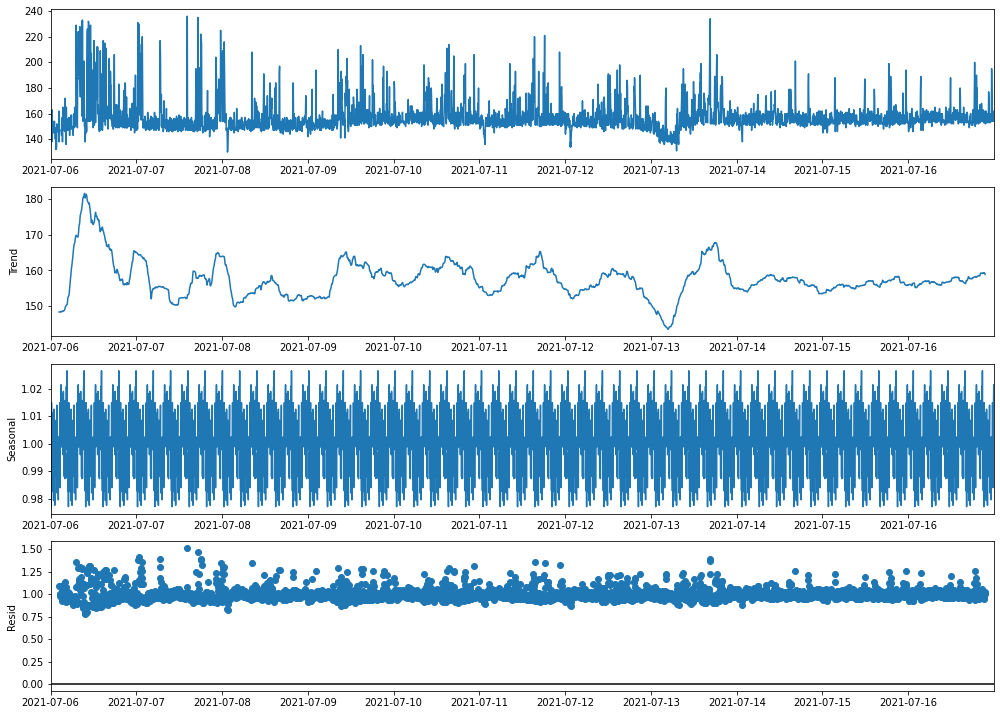

In [25]:
#Seasonal decomposition considering multiplicative model.

import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (14,10)

from statsmodels.tsa.seasonal import seasonal_decompose
decompose_data = seasonal_decompose(df1, model="multiplicative",period=58)
decompose_data.plot()
plt.show()

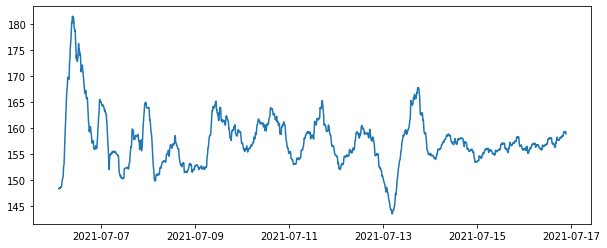

In [26]:
#Trend
plt.rcParams["figure.figsize"] = (10,4)
plt.plot(decompose_data.trend)

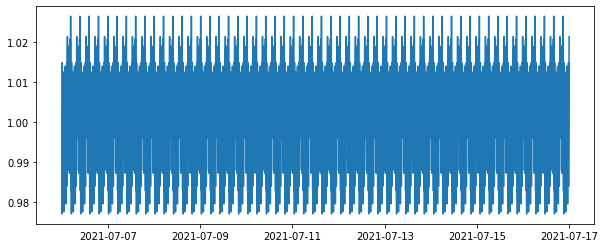

In [27]:
#Seasonal

plt.plot(decompose_data.seasonal)

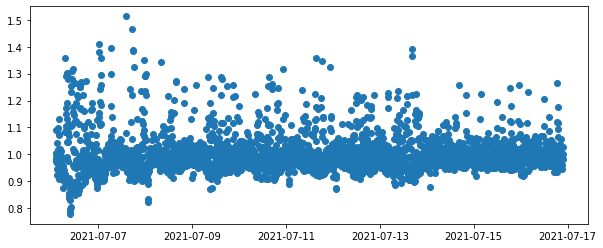

In [28]:
#Residual
plt.scatter(x=df.index,y=decompose_data.resid)

In [29]:
decompose_data.resid.describe()

count    3110.000000
mean        0.999952
std         0.071037
min         0.778732
25%         0.961921
50%         0.985916
75%         1.015996
max         1.513363
Name: resid, dtype: float64

Comparing additive and multiplicative model, it is evident that the residuals of multiplicative model has less auto-correlation between the points hence choosing the same for modelling and forecasting.

By looking at the trend and seasonal component in the above graph, we can find that there is additive trend and multiplicative seasonality in the data.

Holt Winters multiplicative Exponential Smoothing with trend and seasonality.
The Holt-Winters forecasting algorithm allows users to smooth a time series and use that data to forecast areas of interest. Exponential smoothing assigns exponentially decreasing weights and values against historical data to decrease the value of the weight for the older data. As there is additive trend and multiplicative seasonality, we use trend='add' and seasonal='mul'.

<AxesSubplot:title={'center':'Holt Winters graph: Additive Trend and Multiplicative Trend'}, xlabel='Timestamp'>

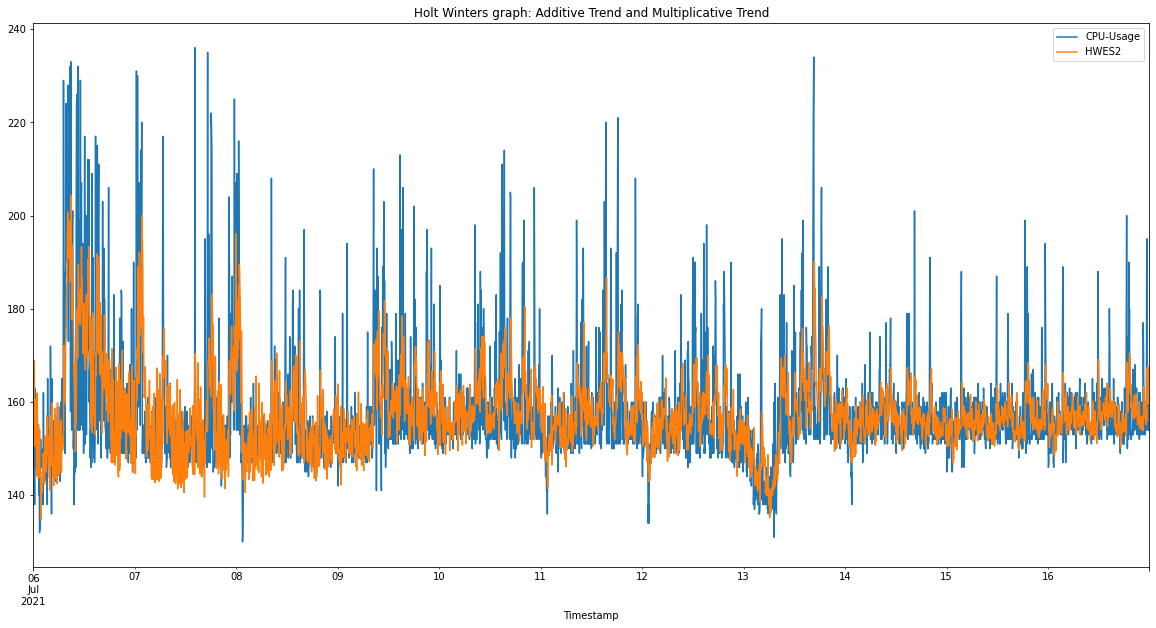

In [30]:
#Holt Winters Exponential smoothing

df1['HWES2'] = ExponentialSmoothing(df1['CPU-Usage'],trend='add',seasonal='mul',seasonal_periods=58,
                                    freq='5T').fit().fittedvalues
df1[['CPU-Usage','HWES2']].plot(title='Holt Winters graph: Additive Trend and Multiplicative Trend',figsize=(20,10))

<b> Splitting the data into small parts for modelling

C:\Users\Samana K\AppData\Roaming\Python\Python39\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning:

No frequency information was provided, so inferred frequency 5T will be used.



Text(0.5, 1.0, 'Train, Test and Predicted data points using Holt Winters Exponential Smoothing')

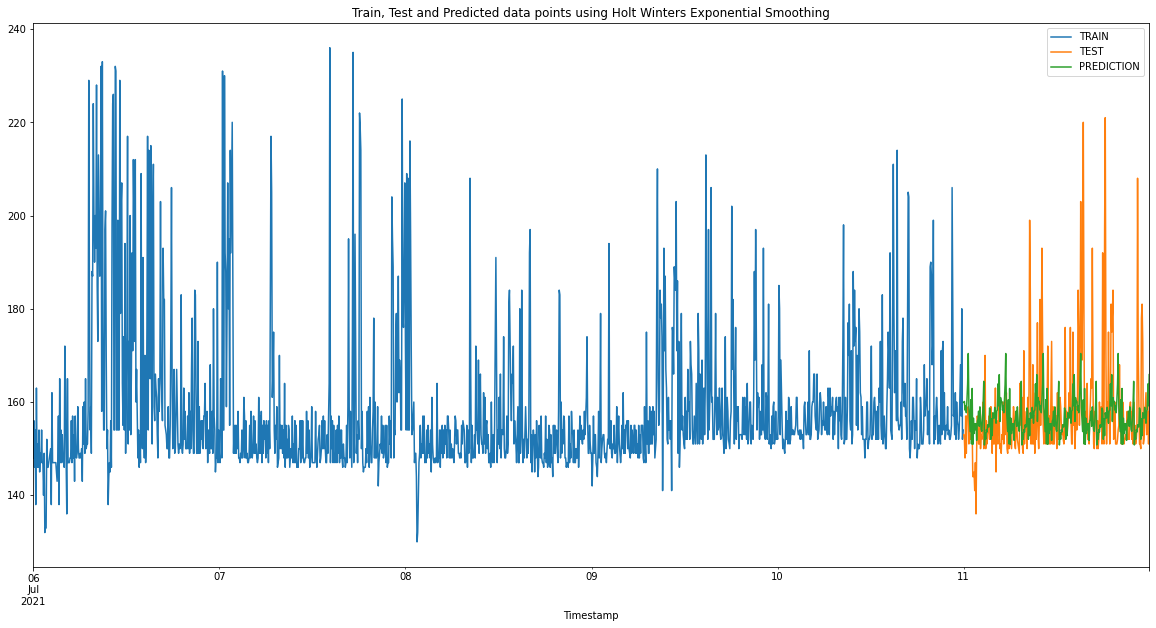

In [31]:
#Splitting the data as train and test for training the model

train_data=df1[:1440]
test_data=df1[1440:1728]

#Fitting the model
fitted_model = ExponentialSmoothing(train_data['CPU-Usage'],seasonal='mul',seasonal_periods=58).fit()
test_predictions = fitted_model.forecast(288)
train_data['CPU-Usage'].plot(legend=True,label='TRAIN')
test_data['CPU-Usage'].plot(legend=True,label='TEST',figsize=(20,10))
test_predictions.plot(legend=True,label='PREDICTION')
plt.title('Train, Test and Predicted data points using Holt Winters Exponential Smoothing')

Text(0.5, 1.0, 'Test and Predicted data points using Holt Winters Exponential Smoothing')

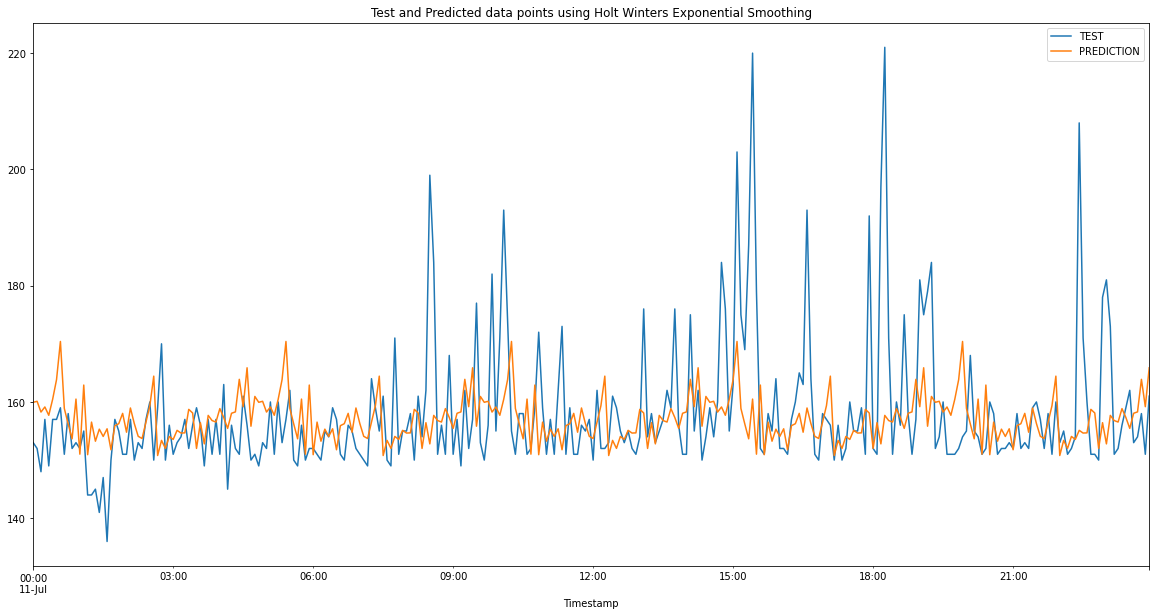

In [32]:
test_data['CPU-Usage'].plot(legend=True,label='TEST',figsize=(20,10))
test_predictions.plot(legend=True,label='PREDICTION')
plt.title('Test and Predicted data points using Holt Winters Exponential Smoothing')

In [33]:
#Calculating MAPE

pred=fitted_model.forecast(288)
actual=test_data['CPU-Usage']
mape = np.mean(np.abs((actual - pred)/actual))*100
mape

4.402926969219905

In [34]:
#Calculating RMSE

RMSE=math.sqrt(mean_squared_error(actual,pred))
RMSE

11.65527265811117